<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/SupplyChain-Analytics/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('https://raw.githubusercontent.com/KarthikeyanBaskaran/SupplyChain-Analytics/refs/heads/main/Rider-Info.csv')

In [63]:
df.head(2)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN


#### Feature engineering

In [69]:
#Selecting Datatypes
df['order_id'] = df['order_id'].astype('object')
df['rider_id'] = df['rider_id'].astype('object')

df['allot_time'] = pd.to_datetime(df['allot_time'], errors='coerce')
df['accept_time'] = pd.to_datetime(df['accept_time'], errors='coerce')
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['pickup_time'] = pd.to_datetime(df['pickup_time'], errors='coerce')
df['delivered_time'] = pd.to_datetime(df['delivered_time'], errors='coerce')
df['cancelled_time'] = pd.to_datetime(df['cancelled_time'], errors='coerce')
df['order_time'] = pd.to_datetime(df['order_time'], errors='coerce')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            450000 non-null  datetime64[ns]
 1   order_id              450000 non-null  object        
 2   order_date            450000 non-null  datetime64[ns]
 3   allot_time            450000 non-null  datetime64[ns]
 4   accept_time           449843 non-null  datetime64[ns]
 5   pickup_time           447579 non-null  datetime64[ns]
 6   delivered_time        444782 non-null  datetime64[ns]
 7   rider_id              450000 non-null  object        
 8   first_mile_distance   450000 non-null  float64       
 9   last_mile_distance    450000 non-null  float64       
 10  alloted_orders        433052 non-null  float64       
 11  delivered_orders      432659 non-null  float64       
 12  cancelled             450000 non-null  int64         
 13 

In [71]:
datetime_cols = [
    'order_time', 'order_date', 'allot_time', 'accept_time',
    'pickup_time', 'delivered_time', 'cancelled_time'
]

datecol = []
timecol = []

# Split each datetime column into date and time parts
for col in datetime_cols:
    df[f'{col}_date'] = pd.to_datetime(df[col], errors='coerce').dt.date
    datecol.append(f'{col}_date')
    df[f'{col}_time'] = pd.to_datetime(df[col], errors='coerce').dt.time
    timecol.append(f'{col}_time')

# Create 'same_day_delivery' column: True if all non-null dates in row are the same
df['same_day_delivery'] = df[datecol].apply(lambda row: len(set(row.dropna())) == 1,axis=1)


for col in datecol:
    df[col] = pd.to_datetime(df[col], errors='coerce')


#### EDA

In [156]:
df.isnull().sum() * 100 / len(df)

,0
order_time,0.000000
order_id,0.000000
order_date,0.000000
allot_time,0.000000
accept_time,0.000000
pickup_time,0.538000
delivered_time,1.159556
rider_id,0.000000
first_mile_distance,0.000000
last_mile_distance,0.000000


In [131]:
import pandas as pd

# Convert to correct types
df['order_date'] = pd.to_datetime(df['order_date'])
df['alloted_orders'] = pd.to_numeric(df['alloted_orders'], errors='coerce')

# Sort for consistency
df = df.sort_values(by=['rider_id', 'order_date'])

# Step 1: Create pivot
pivot = df.pivot_table(index=['order_date', 'rider_id'], values='alloted_orders', aggfunc='first').reset_index()

# Step 2: Create complete grid
riders = df['rider_id'].unique()
dates = df['order_date'].unique()
grid = pd.MultiIndex.from_product([dates, riders], names=['order_date', 'rider_id']).to_frame(index=False)

# Ensure datetime types match
grid['order_date'] = pd.to_datetime(grid['order_date'])
pivot['order_date'] = pd.to_datetime(pivot['order_date'])

# Step 3: Merge to form complete data
pivot_full = grid.merge(pivot, on=['order_date', 'rider_id'], how='left')

# Step 4: Fill missing values
pivot_full['filled_alloted_orders'] = (
    pivot_full.groupby('rider_id')['alloted_orders']
    .ffill()
    .combine_first(
        pivot_full.groupby('rider_id')['alloted_orders'].bfill()
    )
)

# Step 5: Merge back with original df
df = df.merge(
    pivot_full[['order_date', 'rider_id', 'filled_alloted_orders']],
    on=['order_date', 'rider_id'],
    how='left'
)

# Step 6: Fill missing values in original column
df['alloted_orders_filled'] = df['alloted_orders'].combine_first(df['filled_alloted_orders'])
df.drop(columns=['alloted_orders','filled_alloted_orders'], inplace=True)
df.rename(columns={'alloted_orders_filled': 'alloted_orders'}, inplace=True)

#

In [ ]:
df['accept_time_date'].unique()

array([datetime.date(2021, 1, 26), NaT, datetime.date(2021, 1, 27),
       datetime.date(2021, 1, 28), datetime.date(2021, 1, 29),
       datetime.date(2021, 1, 30), datetime.date(2021, 1, 31),
       datetime.date(2021, 2, 1), datetime.date(2021, 2, 2),
       datetime.date(2021, 2, 3), datetime.date(2021, 2, 4),
       datetime.date(2021, 2, 5), datetime.date(2021, 2, 6)], dtype=object)

In [134]:
#fill missing values of accepttime based on riders average accept time

# --- 1. Convert the relevant columns to datetime ---
df['allot_time'] = pd.to_datetime(df['allot_time'], errors='coerce')
df['accept_time'] = pd.to_datetime(df['accept_time'], errors='coerce')

# --- 2. Calculate the delay (in seconds) from allot_time to accept_time ---
df['accept_delay'] = (df['accept_time'] - df['allot_time']).dt.total_seconds()

# --- 3. Compute the average (median) accept delay for each rider ---
rider_avg_accept_delay = (
    df[df['accept_delay'].notna()]
    .groupby('rider_id')['accept_delay']
    .median()
)

# --- 4. Define a function to fill missing accept_time values ---
def fill_accept_time(row):
    if pd.isna(row['accept_time']):
        # Get the rider-specific average delay; if not available, you can use a global average or leave it missing.
        avg_delay = rider_avg_accept_delay.get(row['rider_id'], None)
        if avg_delay is not None:
            # Add the average delay (in seconds) to the allot_time
            return row['allot_time'] + pd.Timedelta(seconds=avg_delay)
        else:
            # Fallback: if no average is available, simply return the allot_time (or consider leaving as NaT)
            return row['allot_time']
    else:
        return row['accept_time']

# --- 5. Apply the function to fill missing accept_time values ---
df['accept_time'] = df.apply(fill_accept_time, axis=1)

In [144]:
df['delivered_orders'] = df['delivered_orders'].fillna(df['alloted_orders'])
df['undelivered_orders'] = df['alloted_orders'] - df['delivered_orders']


In [149]:
df.isnull().sum()

,0
order_time,0
order_id,0
order_date,0
allot_time,0
accept_time,0
pickup_time,2421
delivered_time,5218
rider_id,0
first_mile_distance,0
last_mile_distance,0


In [151]:
dropcol = ['delivered_orders', 'undelivered_orders', 'lifetime_order_count', 'session_time', 'alloted_orders']

In [150]:
# Select columns for numerical analysis
numerical_cols = df.select_dtypes(include=['number']).columns
numerical_cols

Index(['first_mile_distance', 'last_mile_distance', 'delivered_orders',
       'cancelled', 'undelivered_orders', 'lifetime_order_count',
       'reassigned_order', 'session_time', 'alloted_orders', 'accept_delay'],
      dtype='object')

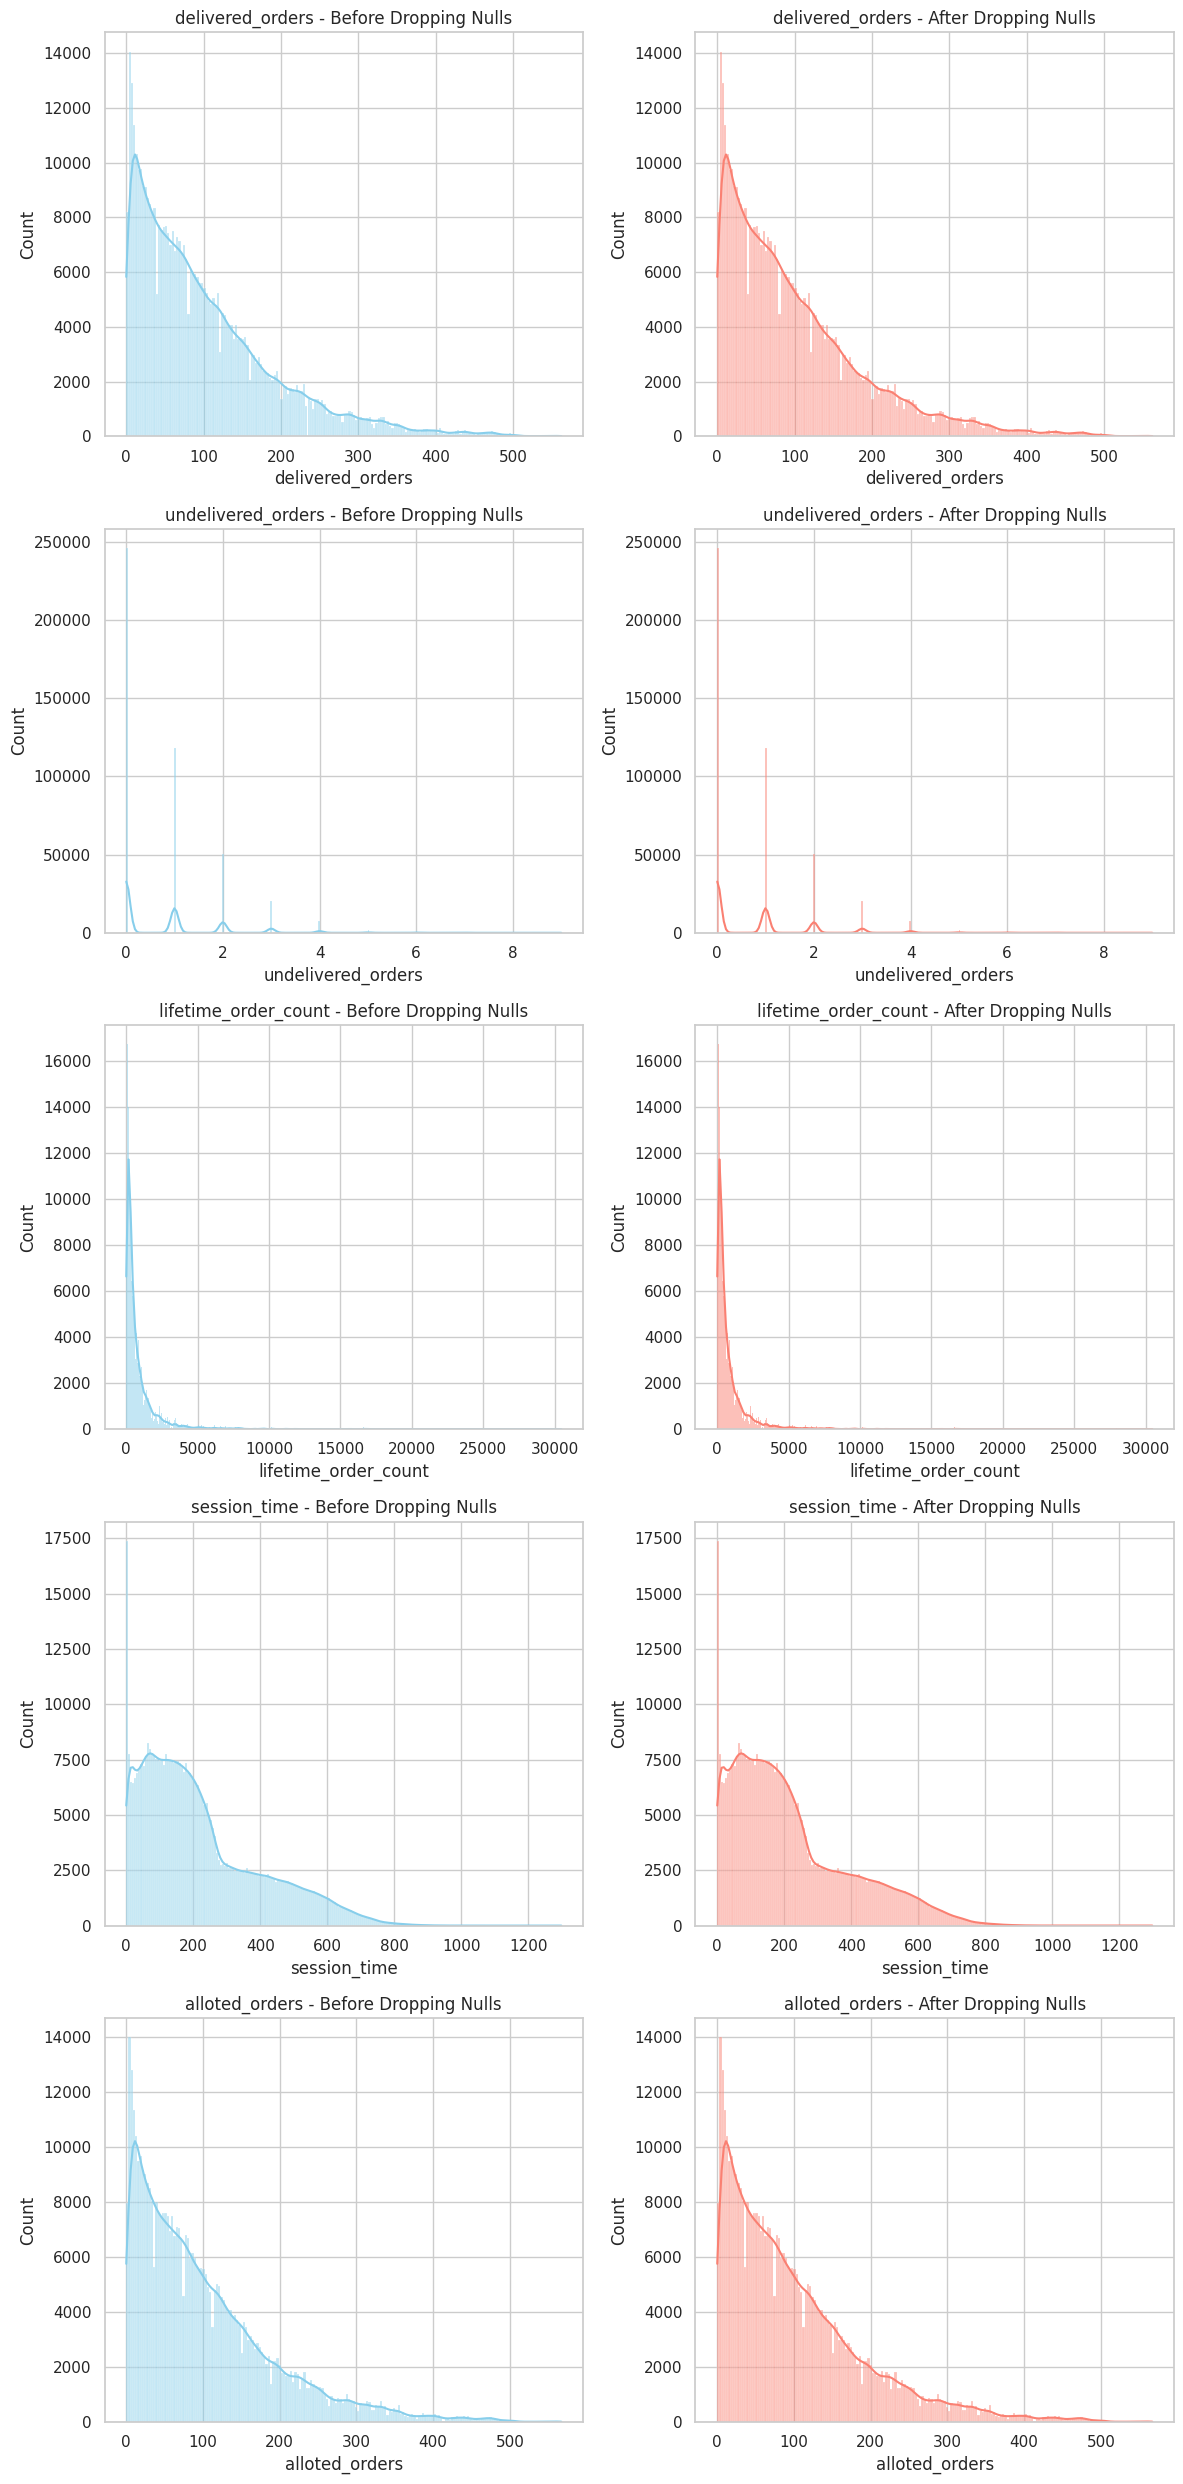

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copy original DataFrame
df_copy = df.copy()

# Set plot style
sns.set(style='whitegrid')
numeric_cols = dropcol

# Create subplots
num_cols = len(numeric_cols)
ncols = 2  # Before and After
nrows = num_cols

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))

# Loop through each numeric column
for i, col in enumerate(numeric_cols):
    # Plot before dropping nulls
    sns.histplot(df_copy[col], ax=axes[i][0], kde=True, color='skyblue')
    axes[i][0].set_title(f"{col} - Before Dropping Nulls")

    # Plot after dropping nulls
    sns.histplot(df_copy[col].dropna(), ax=axes[i][1], kde=True, color='salmon')
    axes[i][1].set_title(f"{col} - After Dropping Nulls")

# Layout adjustment
plt.tight_layout()
plt.show()


In [153]:
numeric_cols

['delivered_orders',
 'undelivered_orders',
 'lifetime_order_count',
 'session_time',
 'alloted_orders']

In [157]:
# Step 4: Drop rows with any nulls in numeric columns
df_cleaned = df_copy.dropna(subset=numeric_cols)
# Step 5: Replace original df with cleaned one
df = df_cleaned.copy()


In [158]:
#fill pickup and delivered time


# --- 1. Ensure proper datatypes for time columns ---
time_cols = ['accept_time', 'pickup_time', 'delivered_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# --- 2. Calculate time durations (in seconds) for rides with available times ---
# Duration for pickup: time from accept_time to pickup_time
df['pickup_duration'] = (df['pickup_time'] - df['accept_time']).dt.total_seconds()

# Duration for delivery: time from pickup_time to delivered_time
df['delivery_duration'] = (df['delivered_time'] - df['pickup_time']).dt.total_seconds()

# --- 3. Compute average time per mile for each segment per rider ---
# For pickup: average seconds per mile (using first_mile_distance)
pickup_time_per_mile = (
    df[df['pickup_duration'].notna()]
    .groupby('rider_id')
    .apply(lambda group: (group['pickup_duration'] / group['first_mile_distance']).median())
)
pickup_time_per_mile.name = 'avg_time_per_mile_pickup'

# For delivery: average seconds per mile (using last_mile_distance)
delivery_time_per_mile = (
    df[df['delivery_duration'].notna()]
    .groupby('rider_id')
    .apply(lambda group: (group['delivery_duration'] / group['last_mile_distance']).median())
)
delivery_time_per_mile.name = 'avg_time_per_mile_delivery'

# Merge these averages back into the main DataFrame on rider_id
df = df.merge(pickup_time_per_mile, on='rider_id', how='left')
df = df.merge(delivery_time_per_mile, on='rider_id', how='left')

# Compute global medians as fallback in case some rider's average is missing
global_avg_pickup = df.loc[df['avg_time_per_mile_pickup'].notna(), 'avg_time_per_mile_pickup'].median()
global_avg_delivery = df.loc[df['avg_time_per_mile_delivery'].notna(), 'avg_time_per_mile_delivery'].median()

# --- 4. Define functions to estimate missing times based on the computed averages ---

def fill_pickup_time(row):
    # If pickup_time is missing but accept_time is available
    if pd.isna(row['pickup_time']) and pd.notna(row['accept_time']):
        # Use rider-specific average if available, else global average
        avg_time = row['avg_time_per_mile_pickup'] if pd.notna(row['avg_time_per_mile_pickup']) else global_avg_pickup
        # Estimate pickup_time: accept_time + (first_mile_distance * avg_time_per_mile)
        estimated_seconds = row['first_mile_distance'] * avg_time
        return row['accept_time'] + pd.Timedelta(seconds=estimated_seconds)
    return row['pickup_time']

def fill_delivered_time(row):
    # If delivered_time is missing but pickup_time is available (after filling)
    if pd.isna(row['delivered_time']) and pd.notna(row['pickup_time']):
        # Use rider-specific average if available, else global average
        avg_time = row['avg_time_per_mile_delivery'] if pd.notna(row['avg_time_per_mile_delivery']) else global_avg_delivery
        # Estimate delivered_time: pickup_time + (last_mile_distance * avg_time_per_mile)
        estimated_seconds = row['last_mile_distance'] * avg_time
        return row['pickup_time'] + pd.Timedelta(seconds=estimated_seconds)
    return row['delivered_time']

# --- 5. Apply the estimation functions to fill missing values ---
df['pickup_time'] = df.apply(fill_pickup_time, axis=1)
df['delivered_time'] = df.apply(fill_delivered_time, axis=1)

# --- 6. (Optional) Drop temporary columns ---
# df.drop(columns=['pickup_duration', 'delivery_duration', 'avg_time_per_mile_pickup', 'avg_time_per_mile_delivery'], inplace=True)


In [163]:
# 1. Time Features
df['order_hour'] = df['order_time'].dt.hour
df['order_dayofweek'] = df['order_time'].dt.dayofweek
df['order_weekday'] = df['order_time'].dt.day_name()

# 2. Delivery Duration
df['delivery_duration_s'] = (df['delivered_time'] - df['pickup_time']).dt.total_seconds() / 60

# 3. Speed Metrics (avoid division by zero)
df['first_mile_speed'] = df['first_mile_distance'] / ((df['pickup_time'] - df['order_time']).dt.total_seconds().replace(0, np.nan))
df['last_mile_speed'] = df['last_mile_distance'] / ((df['delivered_time'] - df['pickup_time']).dt.total_seconds().replace(0, np.nan))

# 4. Rider Performance
df['delivery_rate'] = df['delivered_orders'] / df['alloted_orders'].replace(0, np.nan)
df['undelivery_rate'] = df['undelivered_orders'] / df['alloted_orders'].replace(0, np.nan)

# 5. Binary flag for reassignment
df['was_reassigned'] = (df['reassigned_order'] > 0).astype(int)



In [165]:
df_copy = df.copy()

In [166]:
# Clean infinities or NaNs from feature division
df.replace([np.inf, -np.inf], np.nan, inplace=True)